In [4]:
using Plots
using LaTeXStrings

In [17]:
function circ(x)
    return [x[1],x[2],x[3]+x[1]]
end 

circ (generic function with 2 methods)

### 1.- En clase vimos el método de Euler mejorado en el que nosotros introducimos el Jacobiano de forma analítica para ser evaluado por el método de integración. Realice una función que implemente el mismo método de integración, pero en lugar de calcular el Jacobiano con una función que lo evalúa analíticamente, ahora sea calculado de manera numérica utilizando la derivación numérica.

In [6]:
#jacobiano autónomo general
function jacobiano(xi,h,func)
    m=func(xi)
    jac=zeros(length(func(xi)),length(xi))
    for i in 1:length(func(xi)), j in 1:length(xi)
        xp1=zeros(length(xi))
        xp2=zeros(length(xi))
        for k in 1:length(xi)
            if  k==j #k==i ||
                xp1[k]=xi[j]+h
                xp2[k]=xi[j]-h
            else
                xp1[k]=xi[j]
                xp2[k]=xi[j]
            end
        end
        jac[i,j]=(circ(xp1)[i]-circ(xp2)[i])/(xp1[j]-xp2[j])
    end
    return jac
end

jacobiano (generic function with 1 method)

In [9]:
#jacobiano autónomo general
function jacobianotemp(xi,h,func)
    m=func(xi)
    jac=zeros(length(func(xi)),length(xi))
    for i in 1:length(func(xi)), j in 1:length(xi)
        xp1=zeros(length(xi))
        xp2=zeros(length(xi))
        for k in 1:length(xi)
            if  k==j #k==i ||
                xp1[k]=xi[j]+h
                xp2[k]=xi[j]-h
            else
                xp1[k]=xi[j]
                xp2[k]=xi[j]
            end
        end
        jac[i,j]=(circ(xp1)[i]-circ(xp2)[i])/(xp1[j]-xp2[j])
    end
    return jac
end

jacobianotemp (generic function with 1 method)

In [18]:
x=1,1,1
A=jacobianotemp(x,0.1,circ)

3×3 Array{Float64,2}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 1.0  0.0  1.0

In [24]:
function Euler_mejorado_J(edo,p_ini,t,jacob)
    # Este solo tiene J y g sin dependencia temporal.
    sol = zeros(length(t),length(p_ini))
    sol[1,:] = p_ini
    δ = t[2]-t[1]
    for i in 1:(length(t)-1)
        eva=[sol[1,:],t[i]]
        
        sol[i+1,:] .= sol[i,:] .+ δ .*edo(sol[i,:],t[i])
        sol[i+1,:] .+= 0.5*(δ^2) .*(jacobianotemp(eva,h,t[i]) *edo(sol[i,:],t[i])) # ojo sistema autonomo
    end
    return sol
end

Euler_mejorado_J (generic function with 1 method)

### 2.- Utilizando los integradores de Euler mejorado con Jacobiano analítico, Euler mejorado con Jacobiano numérico, Runge-Kutta de $2^{\circ}$ orden y Runge-Kutta de $4^{\circ}$ orden, encuentre un paso de integración que proporcione una precisión de $10^{−4}$ en la solución para la siguiente ecuación:

$$
\dddot{y} + \ddot{y}^2 - 3\dot{y}^3 + \cos^2{y} = e^{-t}\sin{3t}
$$

### Con condiciones iniciales $\ddot{y}(1)=1$, $\dot{y}(1)=2$, $y(1)=1$. En particular, ¿qué sucede en en $t\in[1,2]$ y $t\in[1,2.1]$?

Transcribimos las funciones Euler mejorado con Jacobiano analítico:

In [47]:
function Euler_mejorado_J_t_p(edo,p_ini,t,jacob)
    # J y g con dependencia temporal y de parametros externos
    sol = zeros(length(t),length(p_ini))
    sol[1,:] = p_ini
    δ = t[2]-t[1]
    for i in 1:(length(t)-1)
        eval_edo = edo(sol[i,:],t[i])
        if length(eval_edo) == length(p_ini)
            sol[i+1,:] .= sol[i,:] .+ δ .*eval_edo
        else
            sol[i+1,:] .= sol[i,:] .+ δ .*eval_edo[1:(end-1)]
        end
        sol[i+1,:] .+= 0.5*(δ^2) .*(jacob(sol[i,:],t[i]) *eval_edo )
    end
    return sol
end

Euler_mejorado_J_t_p (generic function with 2 methods)

Runge-Kutta de 2do orden: 

In [42]:
function RK_2(edo,x_ini,t)
    sol = zeros( length(t) , length(x_ini) )
    sol[1,:] .= x_ini
    δ = t[2]-t[1]
    for i in 1:length(t)-1
        k1 = sol[i,:] .+ 0.5*δ .*edo(sol[i,:],t[i])
        sol[i+1,:] .= sol[i,:] .+ δ*edo(k1,t[i]+0.5*δ)
    end
    return sol
end

RK_2 (generic function with 1 method)

Runge-Kutta de 4to orden:

In [43]:
function RK_4(edo,x_ini,t)
    sol = zeros( length(t) , length(x_ini) )
    sol[1,:] .= x_ini
    δ = t[2]-t[1]
    for i in 1:length(t)-1
        k1 = edo(sol[i,:],t[i])
        k2 = edo(sol[i,:] .+ 0.5*δ.*k1 , t[i] + 0.5*δ)
        k3 = edo(sol[i,:] .+ 0.5*δ.*k2 , t[i] + 0.5*δ)
        k4 = edo(sol[i,:] .+ δ.*k2 , t[i] + δ)
        sol[i+1,:] .= sol[i,:] .+ (δ/6.0).*(k1 .+ 2.0.*k2 .+ 2.0.*k3 .+ k4)
    end
    return sol
end

RK_4 (generic function with 1 method)

Ahora definimos las funciones de las ecuaciones diferenciales. Para ello notemos que podemos reescribir la ecuación diferencial como un sistema de ecuaciones diferenciales:

$$
x_1=y\\
\dot{x}_1 = x_2\\
\dot{x}_2 = x_3\\
\dot{x}_3 = -x_3^2 + 3x_2^3 - \cos^2{(x_1)} + e^{-t}\sin{(3t)}
$$

Y cuyas condiciones iniciales son: $x_1(1)=1$, $x_2(1)=2$ y $x_3(1)=1$. Las cuales, de manera computacional de la siguiente manera

In [49]:
function EDO1(vec,t)
    # vec = [x1, x2, x3]
    dx1 = vec[2]
    dx2 = vec[3]
    dx3 = -vec[3]*vec[3] + 3*vec[2]*vec[2]*vec[2] - cos(vec[1])*cos(vec[1]) + exp(-t)*sin(3*t)
    return [dx1,dx2,dx3,1.0]
end

EDO1 (generic function with 1 method)

Y ahora definimos su Jacobiano analítico

In [45]:
function EDO1_J(vec,t)
    # vec = [x1, x2, x3]
    J = zeros(3,4)
    J[1,2] = 1.0
    J[2,3] = 1.0
    J[3,1] = 2*cos(vec[1])*sin(vec[1])
    J[3,2] = 9*vec[2]*vec[2]
    J[3,3] = -2*vec[3]
    J[3,4] = 3*exp(-1*t)*cos(3*t)-exp(-1*t)*sin(3*t)
    return J
end

EDO1_J (generic function with 1 method)

Ahora resolvamos esta ecuación diferencial con los diversos métodos y presentemos los resultados con una gráfica:

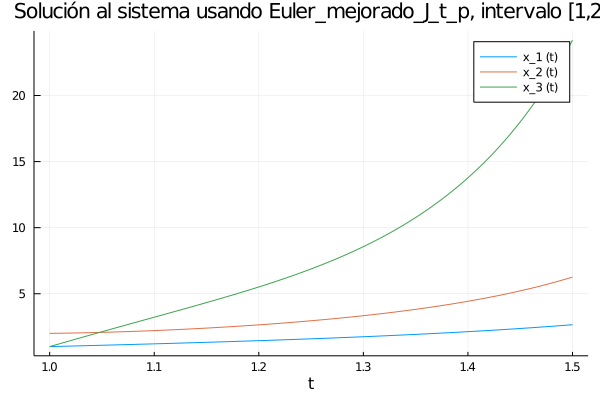

In [50]:
plot(title="Solución al sistema usando Euler_mejorado_J_t_p, intervalo [1,2]",xlabel="t") 
tiempo = collect(1:0.001:1.5)
solucion = Euler_mejorado_J_t_p(EDO1,[1.0,2.0,1.0],tiempo,EDO1_J)
plot!(tiempo,solucion[:,1],label="x_1 (t)")
plot!(tiempo,solucion[:,2],label="x_2 (t)")
plot!(tiempo,solucion[:,3],label="x_3 (t)")

Ahora usando la función

In [ ]:
plot(title="Solución al sistema1 usando MEMA, intervalo [1,2.1]",xlabel="t") 
tiempo = collect(1:0.001:1.7)
solucion = Euler_mejorado_J_t(sistema1_t,[1.0,2.0,1.0],tiempo,sistema1_J)
plot!(tiempo,solucion[:,1],label="x_1 (t)")
plot!(tiempo,solucion[:,2],label="x_2 (t)")
plot!(tiempo,solucion[:,3],label="x_3 (t)")